In [1]:
"""
pcaの次元数を累積寄与率で推定する

結果
lexvec=50
wiki2vec=50
bert = 3

"""

'\npcaの次元数を累積寄与率で推定する\n\n結果\nlexvec=50\nwiki2vec=50\nbert = 3\n\n'

In [1]:
import numpy as np
import gensim
import requests
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
import pandas as pd
from wikipedia2vec import Wikipedia2Vec
import pickle

In [2]:
data = pd.read_csv("3.add_features_data.csv",index_col = 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 0 to 446
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class_a          447 non-null    object 
 1   class_b          447 non-null    object 
 2   relation         447 non-null    object 
 3   type             447 non-null    object 
 4   title            447 non-null    object 
 5   source           447 non-null    object 
 6   sim_by_mcg       440 non-null    float64
 7   is_a_by_mcg      445 non-null    float64
 8   lexvec_sim       447 non-null    float64
 9   wiki2vec_sim     441 non-null    float64
 10  wn_hu_average    447 non-null    float64
 11  wn_pu_average    447 non-null    float64
 12  wn_hu_best       447 non-null    float64
 13  wn_pu_best       447 non-null    float64
 14  wn_sim_path      447 non-null    float64
 15  wn_sim_lch       447 non-null    float64
 16  wn_sim_wup       447 non-null    float64
 17  wn_sim_res      

In [4]:
# 欠損値は最頻値補完を行う
data.loc[:,"sim_by_mcg"] = data.loc[:,"sim_by_mcg"].fillna(data.loc[:,"sim_by_mcg"].mode()[0])
data.loc[:,"is_a_by_mcg"] = data.loc[:,"is_a_by_mcg"].fillna(data.loc[:,"is_a_by_mcg"].mode()[0])
data.loc[:,"wiki2vec_sim"] = data.loc[:,"wiki2vec_sim"].fillna(data.loc[:,"wiki2vec_sim"].mode()[0])
data.loc[:,"wiki2vec_diff"] = data.loc[:,"wiki2vec_diff"].fillna(data.loc[:,"wiki2vec_diff"].mode()[0])
data

,class_a,class_b,relation,type,title,source,sim_by_mcg,is_a_by_mcg,lexvec_sim,wiki2vec_sim,...,wn_sim_wup,wn_sim_res,wn_sim_jcn,wn_sim_lin,has_same_word,is_include_word,bert_sim,lexvec_diff,wiki2vec_diff,bert_diff
0,customer_hobby,customer,s1,analyse,CustomerMerchant,creately,11.743204,0.0,0.528955,0.618602,...,0.562500,3.903153,5.000000e+299,0.500000,1.0,0.0,1.000000,"[0.1353915, -0.074367, -0.024859, 0.0321785, -...","[0.004532963, 0.039239302, -0.17118743, 0.0603...","[-0.01283209, 0.38895035, -0.40116873, 0.21378..."
1,customer,customer_score,s2,analyse,CustomerMerchant,creately,11.662827,0.0,0.568169,0.600282,...,0.558824,3.903153,5.000000e+299,0.500000,1.0,1.0,0.997077,"[-0.0634555, -0.012746997, -0.0277205, -0.0081...","[0.012206405, 0.35635215, 0.33262572, -0.01349...","[0.01283209, -0.38895035, 0.4011687, -0.213786..."
2,merchant,commodity,s2,analyse,CustomerMerchant,creately,0.000000,0.0,0.183820,0.386295,...,0.500000,1.531834,9.437220e-02,0.224280,0.0,0.0,0.940499,"[0.055558994, 0.204258, 0.21276401, -0.1065010...","[-0.06436688, 0.018868487, 0.08909319, -0.2526...","[-0.18334892, -0.07655604, -0.02932033, 0.0077..."
3,customer,customer_hobby,s2,analyse,CustomerMerchant,creately,11.743204,0.0,0.528955,0.618602,...,0.562500,3.903153,5.000000e+299,0.500000,1.0,1.0,0.999658,"[-0.1353915, 0.074367, 0.024859, -0.0321785, 0...","[-0.004532963, -0.039239302, 0.17118743, -0.06...","[-0.24673432, -0.6607137, 0.6385981, -0.403446..."
4,customer,merchant,k,analyse,CustomerMerchant,creately,8.919522,0.0,0.316707,0.241167,...,0.600000,2.333545,8.756056e-02,0.290102,0.0,0.0,0.953543,"[-0.35940498, 0.107147, -0.021296002, 0.121955...","[0.2284539, 0.075674064, 0.13310693, -0.044270...","[-0.5511843, -1.7206957, 1.6635147, -0.957287,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,team,assistant,s2,analyse,web_analyse1,web,1.768339,0.0,0.337900,0.347194,...,0.153846,0.000000,7.403270e-02,0.000000,0.0,0.0,0.968967,"[-0.083178, -0.024441, 0.087414, -0.053188004,...","[-0.5358249, -0.5324029, -0.5566437, 0.208053,...","[-2.9693716, -3.0967522, 1.9765253, -3.558187,..."
443,team,worker,s2,analyse,web_analyse1,web,6.049558,0.0,0.235894,0.201140,...,0.166667,0.000000,8.457223e-02,0.000000,0.0,0.0,0.955652,"[0.016667, 0.049456, -0.007928001, -0.142308, ...","[-0.19864744, -0.35216272, -0.26205117, 0.6510...","[-3.0886095, -3.0115585, 1.8675127, -3.6884851..."
444,team,engineer,s2,analyse,web_analyse1,web,0.000000,0.0,0.289336,0.203954,...,0.166667,0.000000,6.102245e-02,0.000000,0.0,0.0,0.937084,"[-0.101656005, 0.17132601, 0.149645, 0.09675, ...","[-0.20993689, -0.42153573, -0.34714675, 0.5224...","[-2.8990426, -3.049618, 1.8959882, -3.7419803,..."
445,worker,company,s1,analyse,web_analyse1,web,5.879935,0.0,0.279310,0.257664,...,0.166667,0.000000,8.194315e-02,0.000000,0.0,0.0,0.967741,"[-0.054693, -0.018784001, 0.122981995, 0.14338...","[0.1891126, 0.0744792, 0.13534346, -0.4553201,...","[0.04614914, -0.047970742, -0.02745691, -0.115..."


In [5]:
#クラスラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded = le.fit_transform(data['relation'].values)
decoded = le.inverse_transform(encoded)
data.loc[:,'relation_label'] = encoded
print(str(data["relation"].unique())+","+str(le.transform(data["relation"].unique())))
data

['s1' 's2' 'k' 'h1' 'h2'],[3 4 2 0 1]


,class_a,class_b,relation,type,title,source,sim_by_mcg,is_a_by_mcg,lexvec_sim,wiki2vec_sim,...,wn_sim_res,wn_sim_jcn,wn_sim_lin,has_same_word,is_include_word,bert_sim,lexvec_diff,wiki2vec_diff,bert_diff,relation_label
0,customer_hobby,customer,s1,analyse,CustomerMerchant,creately,11.743204,0.0,0.528955,0.618602,...,3.903153,5.000000e+299,0.500000,1.0,0.0,1.000000,"[0.1353915, -0.074367, -0.024859, 0.0321785, -...","[0.004532963, 0.039239302, -0.17118743, 0.0603...","[-0.01283209, 0.38895035, -0.40116873, 0.21378...",3
1,customer,customer_score,s2,analyse,CustomerMerchant,creately,11.662827,0.0,0.568169,0.600282,...,3.903153,5.000000e+299,0.500000,1.0,1.0,0.997077,"[-0.0634555, -0.012746997, -0.0277205, -0.0081...","[0.012206405, 0.35635215, 0.33262572, -0.01349...","[0.01283209, -0.38895035, 0.4011687, -0.213786...",4
2,merchant,commodity,s2,analyse,CustomerMerchant,creately,0.000000,0.0,0.183820,0.386295,...,1.531834,9.437220e-02,0.224280,0.0,0.0,0.940499,"[0.055558994, 0.204258, 0.21276401, -0.1065010...","[-0.06436688, 0.018868487, 0.08909319, -0.2526...","[-0.18334892, -0.07655604, -0.02932033, 0.0077...",4
3,customer,customer_hobby,s2,analyse,CustomerMerchant,creately,11.743204,0.0,0.528955,0.618602,...,3.903153,5.000000e+299,0.500000,1.0,1.0,0.999658,"[-0.1353915, 0.074367, 0.024859, -0.0321785, 0...","[-0.004532963, -0.039239302, 0.17118743, -0.06...","[-0.24673432, -0.6607137, 0.6385981, -0.403446...",4
4,customer,merchant,k,analyse,CustomerMerchant,creately,8.919522,0.0,0.316707,0.241167,...,2.333545,8.756056e-02,0.290102,0.0,0.0,0.953543,"[-0.35940498, 0.107147, -0.021296002, 0.121955...","[0.2284539, 0.075674064, 0.13310693, -0.044270...","[-0.5511843, -1.7206957, 1.6635147, -0.957287,...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,team,assistant,s2,analyse,web_analyse1,web,1.768339,0.0,0.337900,0.347194,...,0.000000,7.403270e-02,0.000000,0.0,0.0,0.968967,"[-0.083178, -0.024441, 0.087414, -0.053188004,...","[-0.5358249, -0.5324029, -0.5566437, 0.208053,...","[-2.9693716, -3.0967522, 1.9765253, -3.558187,...",4
443,team,worker,s2,analyse,web_analyse1,web,6.049558,0.0,0.235894,0.201140,...,0.000000,8.457223e-02,0.000000,0.0,0.0,0.955652,"[0.016667, 0.049456, -0.007928001, -0.142308, ...","[-0.19864744, -0.35216272, -0.26205117, 0.6510...","[-3.0886095, -3.0115585, 1.8675127, -3.6884851...",4
444,team,engineer,s2,analyse,web_analyse1,web,0.000000,0.0,0.289336,0.203954,...,0.000000,6.102245e-02,0.000000,0.0,0.0,0.937084,"[-0.101656005, 0.17132601, 0.149645, 0.09675, ...","[-0.20993689, -0.42153573, -0.34714675, 0.5224...","[-2.8990426, -3.049618, 1.8959882, -3.7419803,...",4
445,worker,company,s1,analyse,web_analyse1,web,5.879935,0.0,0.279310,0.257664,...,0.000000,8.194315e-02,0.000000,0.0,0.0,0.967741,"[-0.054693, -0.018784001, 0.122981995, 0.14338...","[0.1891126, 0.0744792, 0.13534346, -0.4553201,...","[0.04614914, -0.047970742, -0.02745691, -0.115...",3


In [6]:
#label
y = data.loc[:,"relation_label"]

In [7]:
#str_arrをarrに変換
def convert_to_arr(vec_str):
    vec_arr = None
    for s in vec_str:
        if vec_arr is None:
            vec_arr =np.array(s[1:-1].split(", ")).astype("float32")
        else:
            vec_arr = np.block([[vec_arr],[np.array(s[1:-1].split(", ")).astype("float32")]])
    return vec_arr


In [9]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#標準化＋PCA＋累積寄与率
def PCA_flow(X,y):
    scaler = StandardScaler()
    X_ss=scaler.fit_transform(X)
    pca = PCA()
    pca.fit(X_ss)
    ev_ratio = pca.explained_variance_ratio_
    ev_ratio = np.hstack([0,ev_ratio.cumsum()])
    plt.xlabel("Number of Axis", fontsize=10)
    plt.ylabel("Cumulative contribution rate", fontsize=10)
    plt.plot(ev_ratio)
    print(ev_ratio)
    plt.show()

[0.         0.05284949 0.09565593 0.13590845 0.17052026 0.20107283
 0.23042759 0.2586301  0.28592548 0.31126261 0.33401984 0.35547033
 0.37666434 0.39675227 0.41595414 0.43501967 0.45281565 0.47032744
 0.48650289 0.50204778 0.51717162 0.53147358 0.54570681 0.55935597
 0.57273811 0.58600056 0.59807587 0.60997623 0.6216861  0.63253158
 0.64311522 0.65336829 0.66329157 0.67281979 0.68220317 0.69137645
 0.70000297 0.70858294 0.71678376 0.72476941 0.73252589 0.74007243
 0.74742192 0.75458544 0.76156867 0.76838827 0.77487928 0.78112251
 0.78721106 0.79317313 0.7989766  0.80469245 0.81025088 0.81551123
 0.82071048 0.8257075  0.83064628 0.83547741 0.84021062 0.84487361
 0.84940481 0.85386813 0.85807633 0.86219251 0.86609858 0.86991292
 0.87370878 0.87741697 0.88096243 0.88439113 0.88761491 0.89082277
 0.89394557 0.89698857 0.89996839 0.9028976  0.90577066 0.90863192
 0.91134948 0.91399187 0.91653359 0.91899782 0.92145729 0.92383933
 0.92613816 0.92838067 0.9306016  0.93277425 0.93484986 0.9368

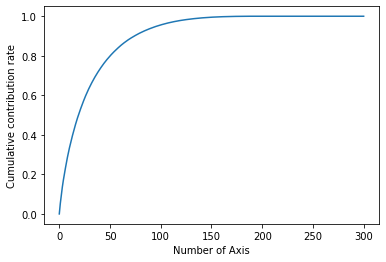

In [10]:
#lexvec
vec_str = data.loc[:,"lexvec_diff"].values
X = convert_to_arr(vec_str)
PCA_flow(X,y)

[0.         0.07190395 0.12087943 0.16254301 0.19685791 0.22886653
 0.2577301  0.28581548 0.31303406 0.33788183 0.36082932 0.38254488
 0.40344563 0.4233689  0.44177452 0.46009189 0.47730252 0.49362296
 0.50898218 0.52347785 0.53762203 0.55162334 0.5653078  0.57865626
 0.59147972 0.6040172  0.61622876 0.62815255 0.63914299 0.65003562
 0.66037858 0.6705004  0.68024653 0.68967003 0.69878489 0.70767993
 0.71623093 0.72431171 0.73221546 0.73979908 0.7470634  0.75425369
 0.76138717 0.76833564 0.77511978 0.78184062 0.78812516 0.79436022
 0.80039275 0.80615389 0.81166774 0.81700021 0.82224649 0.82746816
 0.83247364 0.8372553  0.84194422 0.84657288 0.85104132 0.8554036
 0.85959315 0.86368251 0.86758155 0.8713575  0.87509072 0.87869477
 0.88218534 0.88556695 0.88885993 0.89203888 0.89519078 0.89823711
 0.90123415 0.9041034  0.90691429 0.90970141 0.91237974 0.91503763
 0.91759533 0.92010033 0.92257327 0.92494774 0.92724448 0.92948431
 0.93164068 0.93372643 0.93579465 0.93780756 0.93972802 0.94162

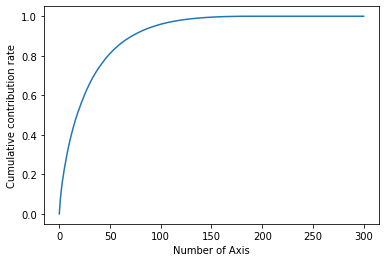

In [11]:
#wiki2vec
vec_str = data.loc[:,"wiki2vec_diff"].values
X = convert_to_arr(vec_str)
PCA_flow(X,y)

[0.         0.7354905  0.80094999 0.86567569 0.90078986 0.92912942
 0.94859457 0.96006846 0.96679485 0.97152978 0.97569859 0.97838706
 0.98087198 0.98317426 0.98506409 0.98642623 0.98767245 0.98872572
 0.98969656 0.99053693 0.99114096 0.99169886 0.99219471 0.99266464
 0.99309981 0.99350911 0.99389613 0.99424076 0.99458379 0.99488103
 0.99515742 0.99542809 0.99566752 0.99589711 0.99611127 0.99631286
 0.99650288 0.99667805 0.99684942 0.99700069 0.99714005 0.99727154
 0.99739385 0.997509   0.997621   0.99772596 0.99782676 0.99792665
 0.99802458 0.99811822 0.9982053  0.99828672 0.99836451 0.99843824
 0.99850744 0.99857306 0.99863338 0.99869221 0.99874759 0.99880284
 0.9988538  0.99890161 0.99894732 0.9989903  0.99903309 0.99907464
 0.99911374 0.99914998 0.99918401 0.99921697 0.99924821 0.99927902
 0.99930817 0.99933594 0.99936247 0.99938834 0.99941272 0.99943614
 0.99945927 0.99948138 0.99950224 0.99952215 0.99954152 0.9995603
 0.99957842 0.99959582 0.99961174 0.99962753 0.99964315 0.99965

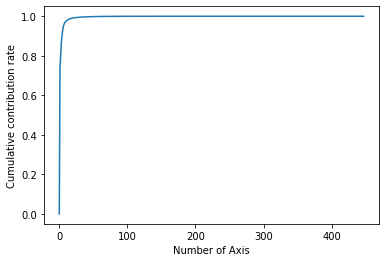

In [12]:
#bert
vec_str = data.loc[:,"bert_diff"].values
X = convert_to_arr(vec_str)
PCA_flow(X,y)